

authors: 
- [ADLANE KADRI](https://www.linkedin.com/in/adlan-kadri-788b66138/)
- [CELINE CHIOUT](https:)

---

**process steps:** 
```
> data preprocessing  ( Feature Transformers functions HERE ) 
> word embeding 
> semantic models
> workflow
> app deployment (flask + docker)
```



## Librires

In [44]:
#For tokenization
from pyspark.ml.feature import Tokenizer, RegexTokenizer
from pyspark.sql.functions import col, udf
from pyspark.sql.types import IntegerType

#for deleting stop words
from pyspark.ml.feature import StopWordsRemover

#viz
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
import shutil
import nltk
import os
import re
import warnings
warnings.simplefilter(action='ignore')
import pandas as pd
#import numpy as np
#from nltk.corpus import stopwords
%matplotlib inline
%load_ext watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


### dataset path 

In [45]:
## define a set of path: 
PATH = os.path.dirname(os.getcwd()) 
dataset_path = os.path.join(PATH, "dataset")

# All Preprocessing Functions

In [46]:
def remove_stop_words(dataset):
    """To delete all stop words
    :param dataset the dataset text we use to remove stop words .
    :type spark dataframe
    :return dataset after deleting stop words
    :type spark.dataframe
    """
    remover = StopWordsRemover(inputCol="words", outputCol="filtered")
    #remover = StopWordsRemover(inputCol="words", outputCol="filtered", stopWords=["*","]", '"',"["])
    filtered = remover.transform(dataset)
    stopWords_removed = filtered.select("filtered", "labels")
    stopWords_removed = stopWords_removed.toPandas()
    #stopWords_removed['reviews'] = [' '.join(map(str, l)) for l in stopWords_removed['filtered']]
    stopWords_removed['reviews'] = [l for l in stopWords_removed['filtered']]
    return stopWords_removed.drop(['filtered'], axis=1)


def tokenize_data(dataset, regexToknizer = False):
    """The process of taking text (such as a sentence) and breaking it into individual terms (usually words)
    :param dataset the dataset text we use to remove stop words .
    :type spark dataframe
    :param regexToknizer a boolean, if we want to use regex to toknize our dataset, by default=False
    :type boolean
    :return dataset after toknization 
    :type spark.dataframe
    """
    tokenizer = Tokenizer(inputCol="reviews", outputCol="words")
    regexTokenizer = RegexTokenizer(inputCol="reviews", outputCol="words", pattern="\\W")

    countTokens = udf(lambda words: len(words), IntegerType())

    tokenized = tokenizer.transform(dataset)
    regexTokenized = regexTokenizer.transform(dataset)
    return regexTokenized if regexToknizer else tokenized

def remove_empty_words_1(dataset):
    for i in range(dataset.shape[0]):
        review= dataset["reviews"][i]
        review=review.lower()
        #review = review.translate(string.maketrans("",""), string.punctuation)
        review = review.strip()

        review=review.replace("<br /><br />"," ")
        review=review.replace("<br />"," ")
        review=review.replace("*"," ")
        review=review.replace("["," ")
        review=review.replace("]"," ")
        review=review.replace('"'," ")
        review=re.sub(' +', ' ', review)
        dataset["reviews"][i] = review 
    return spark.createDataFrame(dataset)

def stemming(dataset):
    stemmer= nltk.stem.PorterStemmer()
    for i in range(dataset.shape[0]):
        dataset.reviews[i] = ([stemmer.stem(token) for token in dataset.reviews[i]])
    return dataset

def lemmatization(dataset):
    lemmatizer = nltk.stem.WordNetLemmatizer()
    for i in range(dataset.shape[0]):
        dataset.reviews[i] = " ".join([lemmatizer.lemmatize(token) for token in dataset.reviews[i]]).strip()
    return dataset
def remove_garbage(dataset):
    garbage = "~`!@#$%^&*()_-+={[}]|\:;'<,>.?/"
    for i in range(dataset.shape[0]):
        dataset.reviews[i] = "".join([char for char in dataset.reviews[i] if char not in garbage])
    return dataset

# Loading data && visialization functions

In [47]:

def load_data(positive_train_data_path, negative_train_data_path):
    """To load data we've reated before
    :param positive_train_data_path the path of all postive reviews
    :type  sting
    :param negative_train_data_path the path of all negative reviews
    :type  sting
    :return a dataset with labels
    :type pandas dataframe
    """
    data = []
    for file in os.listdir(positive_train_data_path):
        with open(os.path.join(positive_train_data_path + file), "r") as f:
            line = f.readlines()[0]
            data.append({"reviews": line, "labels":1})

    for file in os.listdir(negative_train_data_path):
        with open(os.path.join(negative_train_data_path + file), "r") as f:
            line = f.readlines()[0]
            data.append({"reviews": line, "labels":0})

    dataset = pd.DataFrame(data)
    return dataset


def preprocessing():
    """To preprocesse our dataset
    :return a dataset preprocessed
    :type pandas dataframe
    """
    pos_train_data_path = os.path.join(PATH, "dataset", "pos", "")
    neg_train_data_path = os.path.join(PATH, "dataset", "neg", "")
    dataset = load_data(pos_train_data_path, neg_train_data_path)
    dataset_not_treated = dataset.copy()
    #dataset = spark.createDataFrame(dataset)
    
    dataset = remove_empty_words_1(dataset_not_treated)
    dataset = tokenize_data(dataset)
    dataset = remove_stop_words(dataset)
    dataset = stemming(dataset)
    dataset = lemmatization(dataset)
    dataset = remove_garbage(dataset)
    return dataset, dataset_not_treated


def word_cloud_viz(data):
    """To visualize data as word cloud
    :param data to be visualized
    :type  pandas dataframe
    """
    data_1 = data.copy()
    data_1['text']= data_1['reviews'].str.lower()
    all_reviews = data_1['text'].str.split(' ')
    all_reviews.head()

    #import string
    all_reviews_cleaned = []

    for text in all_reviews:
        try:
            all_reviews_cleaned.append(' '.join(str(e) for e in text))
        except: 
            pass
    final_text_reviews = " ".join(all_reviews_cleaned)

    wordcloud_reviews = WordCloud(background_color="black").generate(final_text_reviews)
    plt.figure(figsize = (20,20))
    plt.imshow(wordcloud_reviews, interpolation='bilinear')
    plt.axis("off")
    plt.show()

# Test 

In [ ]:
data_after, data_before = preprocessing()

all_data_xls = os.path.join(PATH, "dataset", "all_data.xlsx")
data_after.to_excel(all_data_xls, index = False, engine='xlsxwriter')

all_data_before_xpath = os.path.join(PATH, "dataset", "all_data_before.xlsx")
data_before.to_excel(all_data_before_xpath, index = False, engine='xlsxwriter')
data_after

In [40]:
data_after

,reviews,labels
0,recent saw movi intern busi class expect anyth...,1
1,featur hammer s allstar highli effect slice b...,1
2,girlfriend thing robots tri seek movi robots m...,1
3,nice pleasant funni earthshattering good jo...,1
4,first instal notori horror seri present woman ...,1
...,...,...
24994,know enki bilal s comic quit time see movie t...,0
24995,script scari movi 2 nt readi go problem film...,0
24996,possibl spoilers movi s reput preced antici...,0
24997,fact like music person opinion histor innacur...,0


# Preprocessing pyspark

In [48]:
all_data_xls = os.path.join(PATH, "dataset", "all_data.xlsx")
all_data_before_xpath = os.path.join(PATH, "dataset", "all_data_before.xlsx")

before = pd.read_excel(all_data_before_xpath)
after = pd.read_excel(all_data_xls)


In [49]:
before

,reviews,labels
0,i recently saw this movie in my international ...,1
1,"featuring a few of hammer's all-stars, this hi...",1
2,my girlfriend and i have a thing for robots. s...,1
3,"nice, pleasant, and funny, but not earth-shatt...",1
4,the first installment of this notorious horror...,1
...,...,...
24994,knowing enki bilal's comics for quite some tim...,0
24995,the script for scary movie 2 just wasn't ready...,0
24996,possible spoilers this movie's reputation pre...,0
24997,the fact that i did not like the music is a ve...,0


In [50]:
after

,labels,reviews
0,1,recent saw movi intern busi class expect anyth...
1,1,featur hammer allstars highli effect slice bri...
2,1,girlfriend thing robots tri seek movi robots m...
3,1,nice pleasant funny earthshattering good job s...
4,1,first instal notori horror seri present woman ...
...,...,...
24994,0,know enki bilal comic quit time see movie thou...
24995,0,script scari movi 2 readi go problem film blat...
24996,0,possibl spoiler movie reput preced it anticip ...
24997,0,fact like music person opinion histor innacura...


# before  treatment

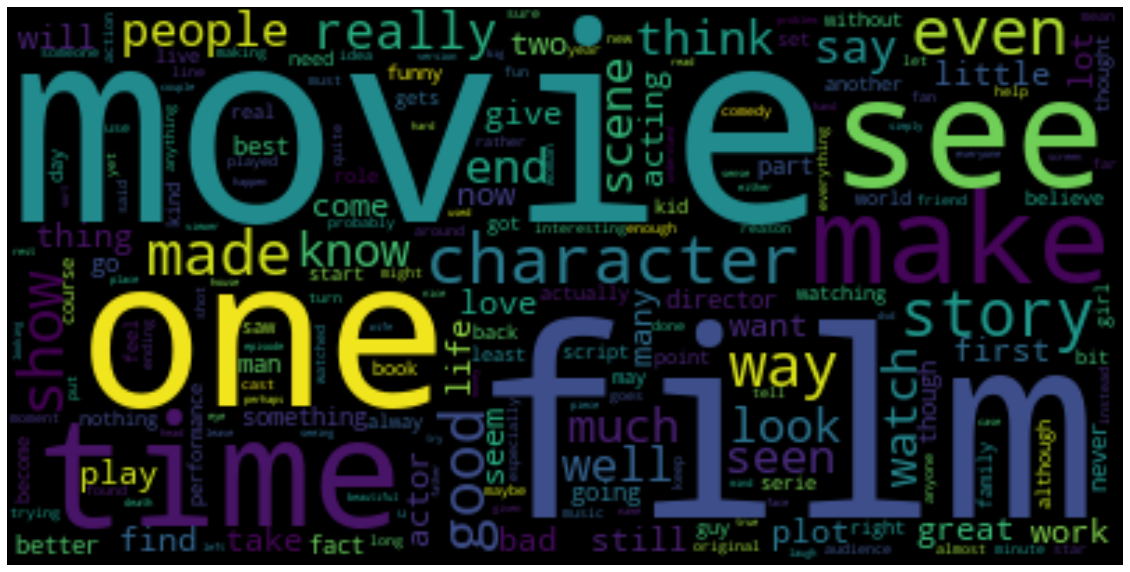

In [51]:
word_cloud_viz(before)

# After  treatment

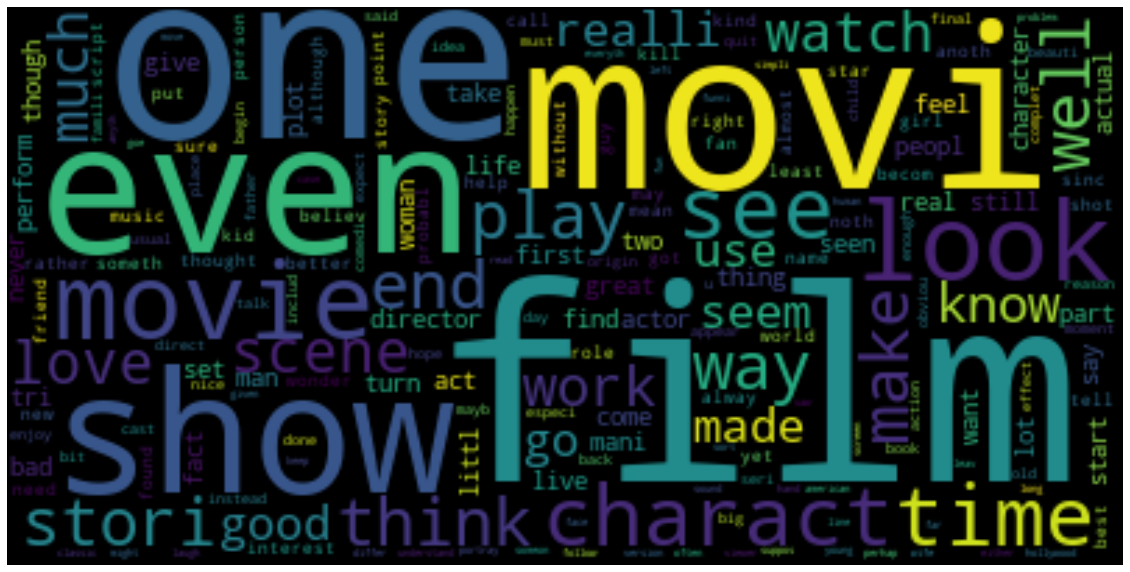

In [52]:
word_cloud_viz(after)